# Chicago taxi rides in 2016

***Work on "Chicago taxi rides in 2016" dataset including :*** 
    
-Clean the datasets (remove outliers, fill missing values)

-Compute interesting derivatives of the datasets

-Extract as many information as possible from the different datasets

-Visualize the data: Draw chart and plot to get more insight into the data


### Getting a sense of the data & preprocessing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [44]:
CHICAGO_TAXI_RIDES_PATH = "./data/chicago-taxi-rides-2016/"

In [7]:
# Generate all the paths to query the data
all_df = []

init_path = CHICAGO_TAXI_RIDES_PATH + "chicago_taxi_trips_2016_"
for i in range (1,13):
    # Append the month to the path
    path = init_path + "{:02d}".format(i) + ".csv"
    # Read the file at the given path
    file_data = pd.read_csv(path)
    # Add the content a list of files content
    all_df.append(file_data)

In [8]:
data = pd.concat(all_df)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19866157 entries, 0 to 1245711
Data columns (total 20 columns):
taxi_id                   float64
trip_start_timestamp      object
trip_end_timestamp        object
trip_seconds              float64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
fare                      float64
tips                      float64
tolls                     float64
extras                    float64
trip_total                float64
payment_type              object
company                   float64
pickup_latitude           float64
pickup_longitude          float64
dropoff_latitude          float64
dropoff_longitude         float64
dtypes: float64(17), object(3)
memory usage: 3.1+ GB


In [10]:
data.shape

(19866157, 20)

In [11]:
data = data.drop(columns= ["trip_seconds", "trip_miles", "pickup_census_tract", "dropoff_census_tract", "fare", "tips", "tolls", "extras", "trip_total", "payment_type", "company"])

In [12]:
data.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,24.0,24.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,6.0,6.0,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,32.0,NaN,385.0,478.0,NaN,NaN


In [13]:
import pickle

# If file exists then load it
try:
    taxi_rides_init = pickle.load(open(CHICAGO_TAXI_RIDES_PATH + "taxi_rides_init.pickle", "rb"))
# Otherwise create it
except (OSError, IOError) as e:
    taxi_rides_init = data
    pickle.dump(taxi_rides_init, open(CHICAGO_TAXI_RIDES_PATH + "taxi_rides_init.pickle", "wb"))

_Let's look at the types of the data:_

In [15]:
taxi_rides_init.dtypes

taxi_id                   float64
trip_start_timestamp       object
trip_end_timestamp         object
pickup_community_area     float64
dropoff_community_area    float64
pickup_latitude           float64
pickup_longitude          float64
dropoff_latitude          float64
dropoff_longitude         float64
dtype: object

In [16]:
taxi_rides_init.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,24.0,24.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,6.0,6.0,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,32.0,NaN,385.0,478.0,NaN,NaN


_We can see here that a lot of types could be simplified using integers. We can also parse the different times as well as trip times. Also, there is some null values in the data. Let's have a look at it._

In [19]:
taxi_rides_init.isnull().sum()

taxi_id                      2933
trip_start_timestamp            0
trip_end_timestamp           2413
pickup_community_area     2755980
dropoff_community_area    3086050
pickup_latitude           2755600
pickup_longitude          2755600
dropoff_latitude          3047662
dropoff_longitude         3047662
dtype: int64

In [21]:
# Convert the latitude and longitude features into their actual values.
def convert_coord(coord, nb):
    s = str(coord)
    res=""
    if nb == 1:
        res = "41.8"+s.split('.')[0]+s.split('.')[1]
    else: 
        res = "-87.6"+s.split('.')[0]+ s.split('.')[1]
    return float(res)

_We have a lot of null values. As we are really interested in the locations, we are going to drop the entries that have missing values._

In [27]:
taxi_rides_init = taxi_rides_init.dropna(subset=['taxi_id', 'pickup_community_area',
                                                 'dropoff_community_area',
                                                 'pickup_latitude',
                                                 'pickup_longitude', 
                                                 'dropoff_latitude',
                                                 'dropoff_longitude'])

In [31]:
taxi_rides_init.trip_start_timestamp = pd.to_datetime(taxi_rides_init.trip_start_timestamp, format='%Y-%m-%d %H:%M:%S')
taxi_rides_init.trip_end_timestamp = pd.to_datetime(taxi_rides_init.trip_end_timestamp, format='%Y-%m-%d %H:%M:%S')

AttributeError: 'Series' object has no attribute 'total_seconds'

In [ ]:
taxi_rides_init['month'] = taxi_rides_init.trip_start_timestamp.apply(lambda x: x.month)
taxi_rides_init['day'] = taxi_rides_init.trip_start_timestamp.apply(lambda x: x.day)
taxi_rides_init['start_hour'] = taxi_rides_init.trip_start_timestamp.apply(lambda x: x.hour)

In [34]:
taxi_rides_init['duration'] = (taxi_rides_init.trip_end_timestamp 
                               - taxi_rides_init.trip_start_timestamp).apply(lambda x : x.total_seconds())

In [36]:
# Replace the latitude and longitude 
taxi_rides_init['pickup_latitude'] = taxi_rides_init['pickup_latitude'].apply(lambda x: convert_coord(x, 1))
taxi_rides_init['pickup_longitude'] = taxi_rides_init['pickup_longitude'].apply(lambda x: convert_coord(x, 2))
taxi_rides_init['dropoff_latitude'] = taxi_rides_init['dropoff_latitude'].apply(lambda x: convert_coord(x, 1))
taxi_rides_init['dropoff_longitude'] = taxi_rides_init['dropoff_longitude'].apply(lambda x: convert_coord(x, 2))

_Now let's have a look at our new data to see how clean it is._

_Something that we can do is replace the data types to reduce the size of the data in memory._

In [37]:
taxi_rides_init.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,month,may,start_hour,duration
0,85.0,2016-01-13 06:15:00,2016-01-13 06:15:00,24.0,24.0,41.8199,-87.6510,41.8199,-87.6510,1,13,6,0.0
3,4237.0,2016-01-23 17:30:00,2016-01-23 17:30:00,6.0,6.0,41.8686,-87.6500,41.8686,-87.6500,1,23,17,0.0
5,1987.0,2016-01-08 18:15:00,2016-01-08 18:45:00,8.0,3.0,41.8599,-87.6346,41.8660,-87.6120,1,8,18,1800.0
7,6400.0,2016-01-26 04:15:00,2016-01-26 04:15:00,16.0,16.0,41.8527,-87.6240,41.8527,-87.6240,1,26,4,0.0
8,7418.0,2016-01-22 11:30:00,2016-01-22 11:45:00,8.0,32.0,41.8210,-87.6470,41.8744,-87.6605,1,22,11,900.0


In [38]:
taxi_rides_init.dtypes

taxi_id                          float64
trip_start_timestamp      datetime64[ns]
trip_end_timestamp        datetime64[ns]
pickup_community_area            float64
dropoff_community_area           float64
pickup_latitude                  float64
pickup_longitude                 float64
dropoff_latitude                 float64
dropoff_longitude                float64
month                              int64
may                                int64
start_hour                         int64
duration                         float64
dtype: object

In [39]:
taxi_rides_init['taxi_id'] = taxi_rides_init['taxi_id'].apply(lambda x : int(x))
taxi_rides_init['pickup_community_area'] = taxi_rides_init['pickup_community_area'].apply(lambda x : int(x))
taxi_rides_init['dropoff_community_area'] = taxi_rides_init['dropoff_community_area'].apply(lambda x : int(x))
taxi_rides_init['duration'] = taxi_rides_init['duration'].apply(lambda x : int(x))

In [43]:
taxi_rides_init['duration'].value_counts().head(10)

900     8086352
0       6046981
1800    1622074
2700     574762
3600     210229
4500      62017
5400      16472
6300       5095
7200       2406
8100       1539
Name: duration, dtype: int64

_We can see that a lot of drives have a duration of 0 minutes. Some have negative durations too. We can consider that those drives are erroneous and will therefore delete them._

In [49]:
taxi_rides_init = taxi_rides_init[taxi_rides_init['duration'] > 0]

In [51]:
taxi_rides_init['duration'].value_counts().head()

900     8086352
1800    1622074
2700     574762
3600     210229
4500      62017
Name: duration, dtype: int64

In [53]:
del taxi_rides_init['trip_start_timestamp']
del taxi_rides_init['trip_end_timestamp']

_Now that our data is cleaner, let's looks at the number of taxis drive per comminity areas in chicago._

In [54]:
# First, let's save the data in a pickle file that we can reuse in the future
# If file exists then load it
try:
    taxi_rides = pickle.load(open(CHICAGO_TAXI_RIDES_PATH + "taxi_rides.pickle", "rb"))
# Otherwise create it
except (OSError, IOError) as e:
    taxi_rides = taxi_rides_init
    pickle.dump(taxi_rides, open(CHICAGO_TAXI_RIDES_PATH + "taxi_rides.pickle", "wb"))

In [60]:
community_area_min = min(np.min(data["pickup_community_area"]), np.min(data["dropoff_community_area"]))
community_area_max = max(np.max(data["pickup_community_area"]), np.max(data["dropoff_community_area"]))
community_area_range = int(community_area_max - community_area_min)
community_area_range

76

Text(0.5, 0, 'Community area')

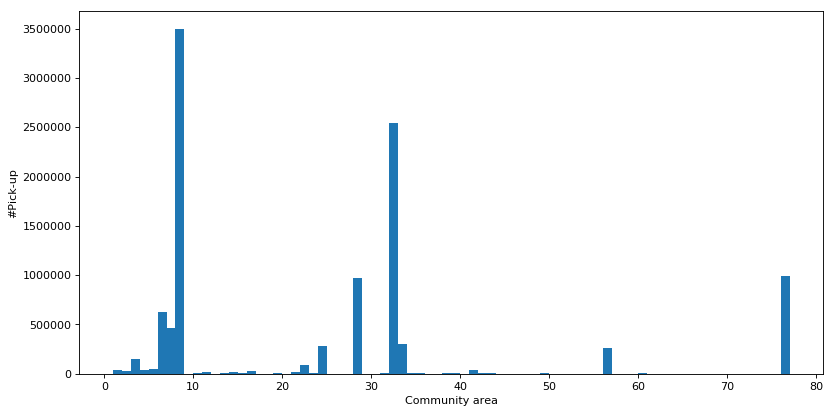

In [63]:
plt.figure(figsize=(12, 6), dpi = 80)
ax, _, _ = plt.hist(taxi_rides["pickup_community_area"], bins = community_area_range)
plt.ylabel('#Pick-up')
plt.xlabel('Community area')

_From the plot above, we can see that only a few community areas have much more taxi rides departure than others. A guess could be that those areas are either rich residence, very urban areas, or transport areas (ex. Airport, Train station, ..)._


_Let's now have a look at the dropoff_\__community_\__areas:_ 

Text(0.5, 0, 'Community area')

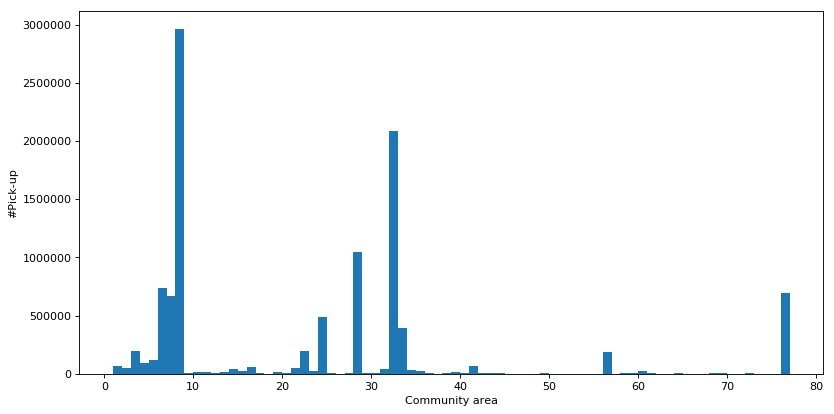

In [64]:
plt.figure(figsize=(12, 6), dpi = 80)
ax, _, _ = plt.hist(taxi_rides["dropoff_community_area"], bins = community_area_range)
plt.ylabel('#Pick-up')
plt.xlabel('Community area')

_Let's look at the sum between pickup and drop off areas to look at the most and least frequented areas._

In [105]:
total_area_frequency = taxi_rides["pickup_community_area"].value_counts() + taxi_rides["dropoff_community_area"].value_counts()

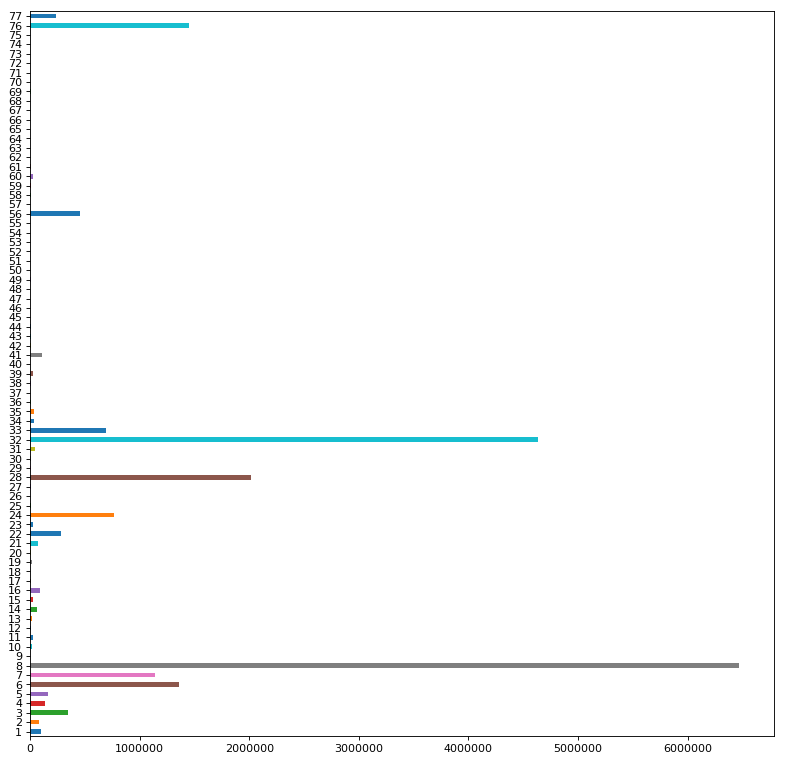

In [111]:
plt.figure(figsize=(12, 12), dpi = 80)
total_area_frequency.plot(kind='barh')

_We can see here that the important pickup and dropoff areas are the same._

_Let's look at the relationship between pickup and dropoff areas:_

In [88]:
taxi_rides["pickup_community_area"].value_counts().head()

8     3499130
32    2547472
28     970935
76     894988
6      622094
Name: pickup_community_area, dtype: int64

In [80]:
np.sort(taxi_rides["pickup_community_area"].value_counts().index)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77])

_Let's select the main taxis areas and show them on a map. We are fixing a thereshold to more than 200000 trips._

In [73]:
# Get a list of the main taxi rides areas
main_areas = taxi_rides["pickup_community_area"].value_counts().where(lambda x : x > 200000).dropna().index.values
main_areas

array([ 8, 32, 28, 76,  6,  7, 33, 24, 56])

_We are also going to have a look to the least frequented areas:_

In [93]:
least_areas = taxi_rides["pickup_community_area"].value_counts().tail(10).index.values

In [97]:
taxi_main_areas_rides = taxi_rides[taxi_rides['pickup_community_area'].apply(lambda x : x in main_areas)]

In [98]:
taxi_main_areas_rides.shape

(9842959, 11)

In [99]:
taxi_least_areas_rides = taxi_rides[taxi_rides['pickup_community_area'].apply(lambda x: x in least_areas)]

From now on we will work with the 15 less frequented areas 
To refine my analysis I decide to study the sum of pick ups and dropoffs

In [30]:
less_freq_count = do_nb+pu_nb #Areas with total frequentation (drop off + pick up)

In [31]:
less_freq_count = less_freq_count.sort_values().head(15)

Text(0.5, 0, '#PU+DO')

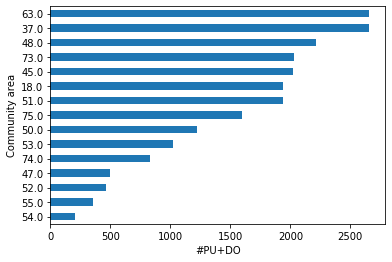

In [32]:
p = less_freq_count.plot(kind = 'barh')
p.set_ylabel("Community area")
p.set_xlabel('#PU+DO')

I'm going to stick with the 4 less frequented areas wich are : 
- RIVERDALE
- HEGEWISH
- EAST SIDE
- BURNSIDE

In [33]:
most_freq = pu_ca[2:10] # most frequented areas without first two to have more significant results
less_freq = [54.0, 55.0, 52.0, 47.0] # 4 less frequented areas

In [34]:
data_less_freq_pu = data[data["pickup_community_area"].isin(less_freq)]

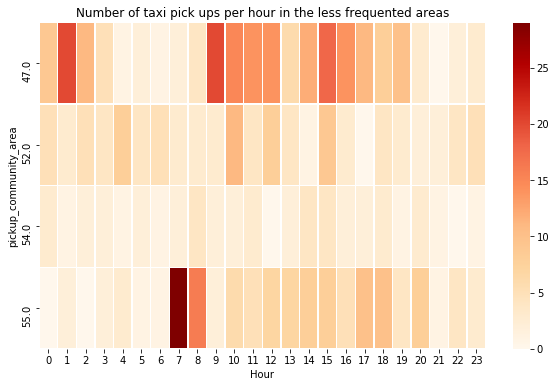

In [35]:
hour_pu = data_less_freq_pu[["pickup_community_area","Hour","taxi_id"  ]].groupby(["pickup_community_area", "Hour"]).count()
hour_pu = hour_pu.rename(columns={'taxi_id':'Count'})
hour_pu = hour_pu.reset_index()
hour_pu = hour_pu.pivot("pickup_community_area","Hour","Count").fillna(0)
fig, ax = plt.subplots(figsize=(10,6))      
plt.title("Number of taxi pick ups per hour in the less frequented areas")
sns.heatmap(hour_pu, linewidths=.5, ax=ax, cmap="OrRd")

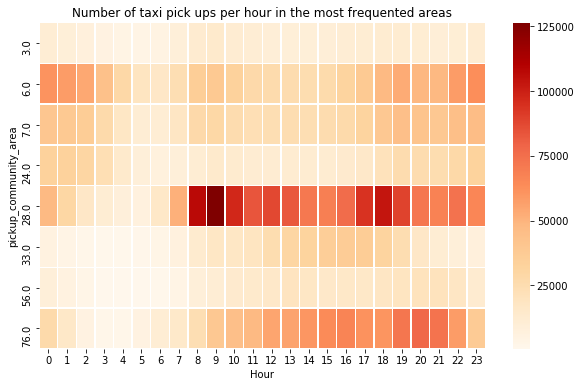

In [36]:
data_most_freq_pu = data[data["pickup_community_area"].isin(most_freq)]
hour_pu = data_most_freq_pu[["pickup_community_area","Hour","taxi_id"  ]].groupby(["pickup_community_area", "Hour"]).count()
hour_pu = hour_pu.rename(columns={'taxi_id':'Count'})
hour_pu = hour_pu.reset_index()
hour_pu = hour_pu.pivot("pickup_community_area","Hour","Count").fillna(0)
fig, ax = plt.subplots(figsize=(10,6))      
plt.title("Number of taxi pick ups per hour in the most frequented areas")
sns.heatmap(hour_pu, linewidths=.5, ax=ax, cmap="OrRd")

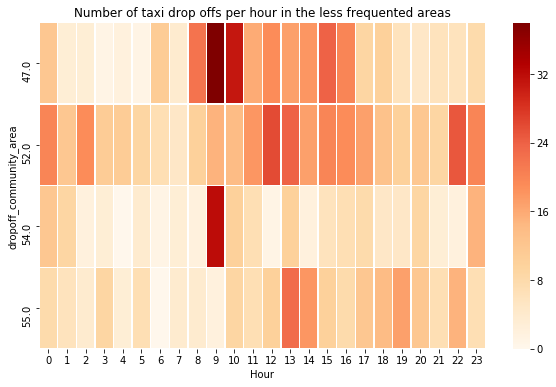

In [37]:
data_less_freq_do = data[data["dropoff_community_area"].isin(less_freq)]
hour_pu = data_less_freq_do[["dropoff_community_area","Hour","taxi_id"  ]].groupby(["dropoff_community_area", "Hour"]).count()
hour_pu = hour_pu.rename(columns={'taxi_id':'Count'})
hour_pu = hour_pu.reset_index()
hour_pu = hour_pu.pivot("dropoff_community_area","Hour","Count").fillna(0)
fig, ax = plt.subplots(figsize=(10,6))      
plt.title("Number of taxi drop offs per hour in the less frequented areas")
sns.heatmap(hour_pu, linewidths=.5, ax=ax, cmap="OrRd")

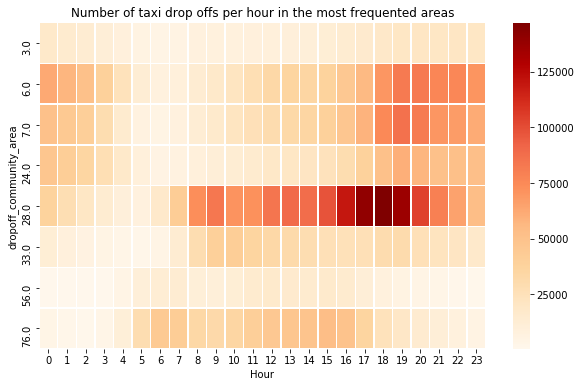

In [38]:
data_most_freq_pu = data[data["dropoff_community_area"].isin(most_freq)]
hour_pu = data_most_freq_pu[["dropoff_community_area","Hour","taxi_id"  ]].groupby(["dropoff_community_area", "Hour"]).count()
hour_pu = hour_pu.rename(columns={'taxi_id':'Count'})
hour_pu = hour_pu.reset_index()
hour_pu = hour_pu.pivot("dropoff_community_area","Hour","Count").fillna(0) 
fig, ax = plt.subplots(figsize=(10,6))      
plt.title("Number of taxi drop offs per hour in the most frequented areas")
sns.heatmap(hour_pu, linewidths=.5, ax=ax, cmap="OrRd")

In [39]:
#Function to generate a base map to work on with
def gen_map(default_loc =[41.84, -87.623177], default_zoom = 12):
    base_map = folium.Map(location = default_loc, control_scale=True, zoom_start=default_zoom)
    return base_map

In [43]:
from folium.plugins import HeatMap
data_copy_pu = data.copy()
data_copy_pu['count'] = 1
base_map_pu = gen_map()
HeatMap(data=data_copy_pu[['gen_pickup_latitude', 'gen_pickup_longitude', 'count']].groupby(['gen_pickup_latitude', 'gen_pickup_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map_pu)

### Heat Map of the number of pick-ups

In [44]:
base_map_pu

In [45]:
data_copy_do = data.copy()
data_copy_do['count'] = 1
base_map_do = gen_map()
HeatMap(data=data_copy_do[['gen_dropoff_latitude', 'gen_dropoff_longitude', 'count']].groupby(['gen_dropoff_latitude', 'gen_dropoff_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map_do)

### Heat Map of the number of drop-offs

In [46]:
base_map_do

In [ ]:
data_hour_list = []
for hour in data_copy_pu.Hour.sort_values().unique():
    data_hour_list.append(data_copy_pu.loc[data_copy_pu.Hour == hour, ['gen_pickup_latitude', 'gen_pickup_longitude', 'count']].groupby(['gen_pickup_latitude', 'gen_pickup_longitude']).sum().reset_index().values.tolist())

In [ ]:
from folium.plugins import HeatMapWithTime
base_map = gen_map()
HeatMapWithTime(data_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8).add_to(base_map)
base_map